# Impact Chart Demo

In [1]:
import itertools

import censusdis.data as ced
from censusdis.datasets import ACS5
import censusdis.states as states

import pandas as pd

from scipy import stats

from impactchart.model import XGBoostImpactModel

import impactchartdemo.data.homeowners as dataset

from matplotlib.ticker import FuncFormatter, PercentFormatter

## Load our Data Set

In this demonstration, we will use a dataset with features representing the fraction of the population in an 
area that identifies as each of one of several demographic groups and a feature for the median income in the
area. The target variable is the median home value in the area. When all is said and done, there will be one
impact chart for each feature, showing the impact of different values of that feature that we observe in the 
data set on the target.

The areas we will use are all of the block groups in a single U.S. Census Core Based Statistical Area (CBSA).
A CBSA is what is commonly known as a metro area.

In [2]:
# There are over 900 CBSAs. If you want to locate one you are interested in,
# try changing `my_cbsa_name` and running the following code. You may get 
# several results. Choose the one you want and set `CBSA` in the following
# cell.

df_cbsas = dataset.all_cbsas()

# Set accordingly.
my_cbsa_name = 'Los Angeles'

df_cbsas[df_cbsas['NAME'].str.contains(my_cbsa_name)].reset_index(drop=True)

,METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA,NAME
0,31080,"Los Angeles-Long Beach-Anaheim, CA Metro Area"


In [3]:
# What CBSA
# CBSA = '40060'  # Richmond, VA
# CBSA = '12060'  # Atlanta, GA
CBSA = '31080'  # Los Angeles

In [4]:
X, y, w, feature_names, target_name = dataset.features(CBSA)

## Generate the Impact Charts

In [5]:
impact_model = XGBoostImpactModel(
    random_state=0x61E77BE9, 
    optimization_scoring_metric='neg_mean_absolute_percentage_error',
)

In [6]:
%%time

impact_model.fit(X, y, sample_weight=w)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [7]:
# Some formatters to make the charts look nice.

dollar_formatter = FuncFormatter(
    lambda d, pos: f"\\${d:,.0f}" if d >= 0 else f"(\\${-d:,.0f})"
)

percent_formatter = PercentFormatter(1.0, decimals=0)

 97%|=================== | 6909/7125 [00:23<00:00]       

CPU times: user 18min 53s, sys: 17.1 s, total: 19min 10s
Wall time: 21min 33s


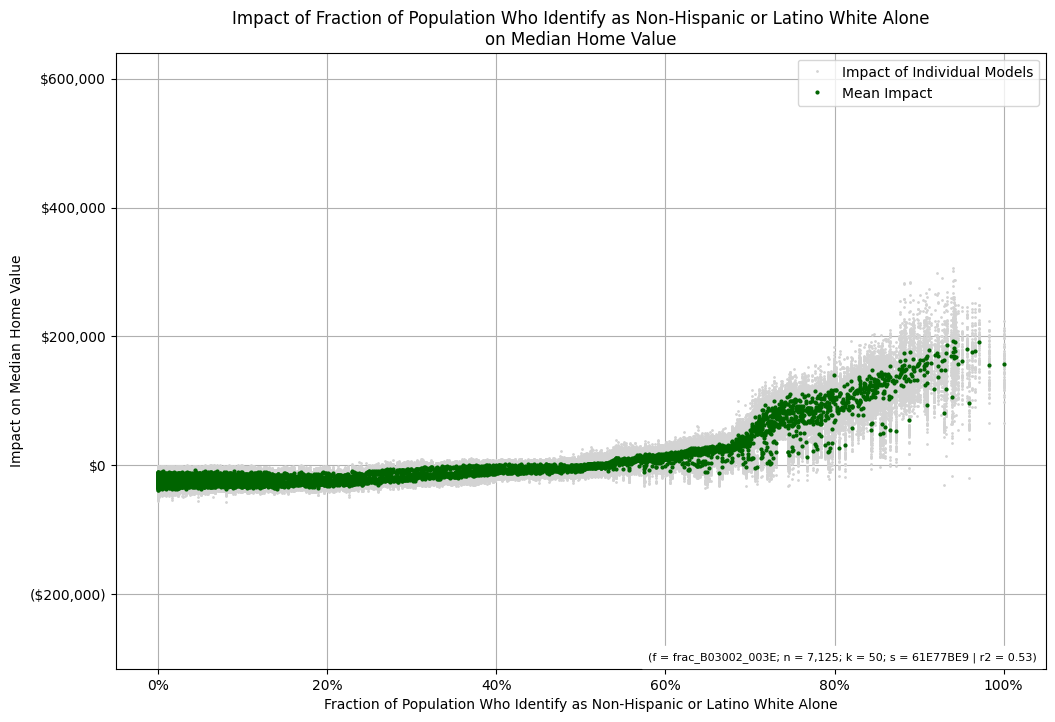

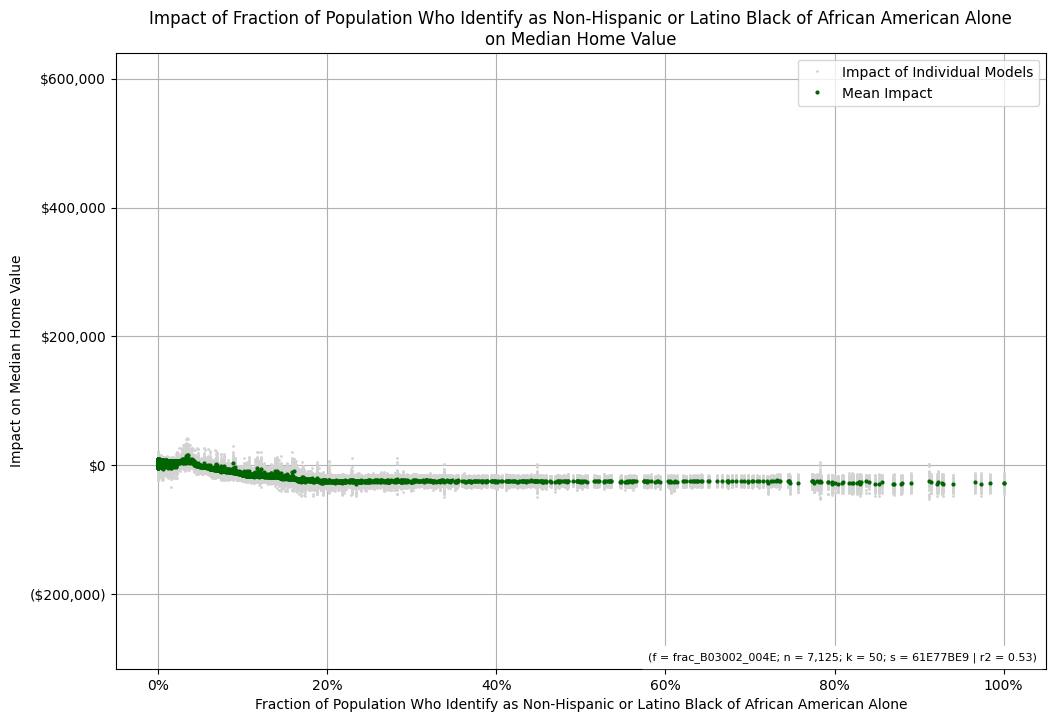

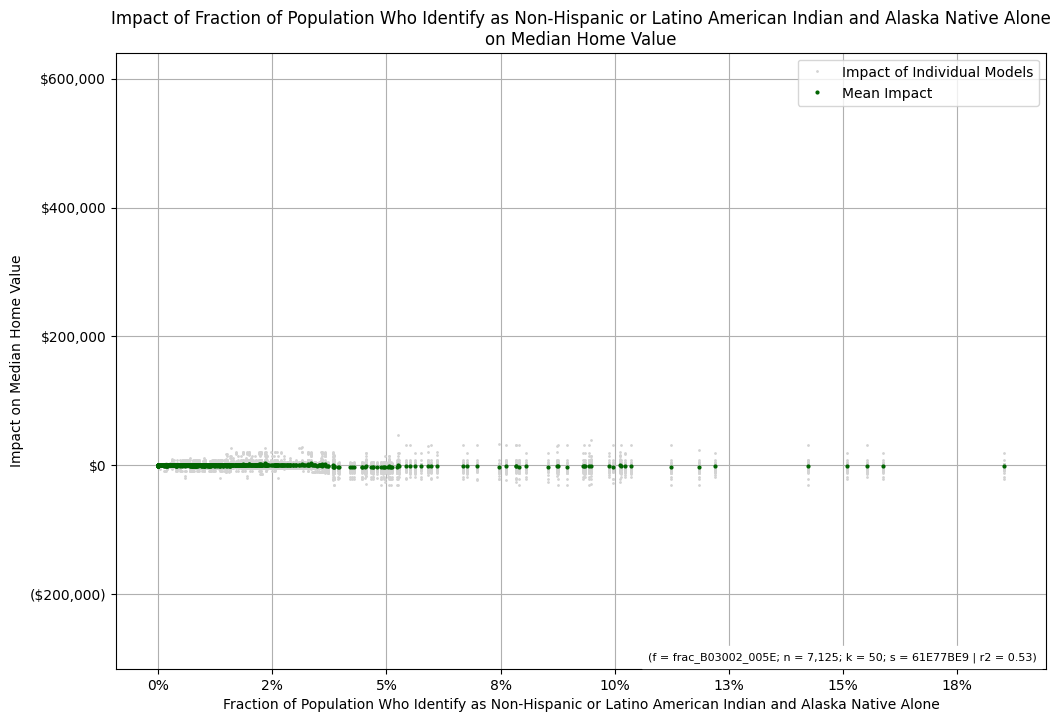

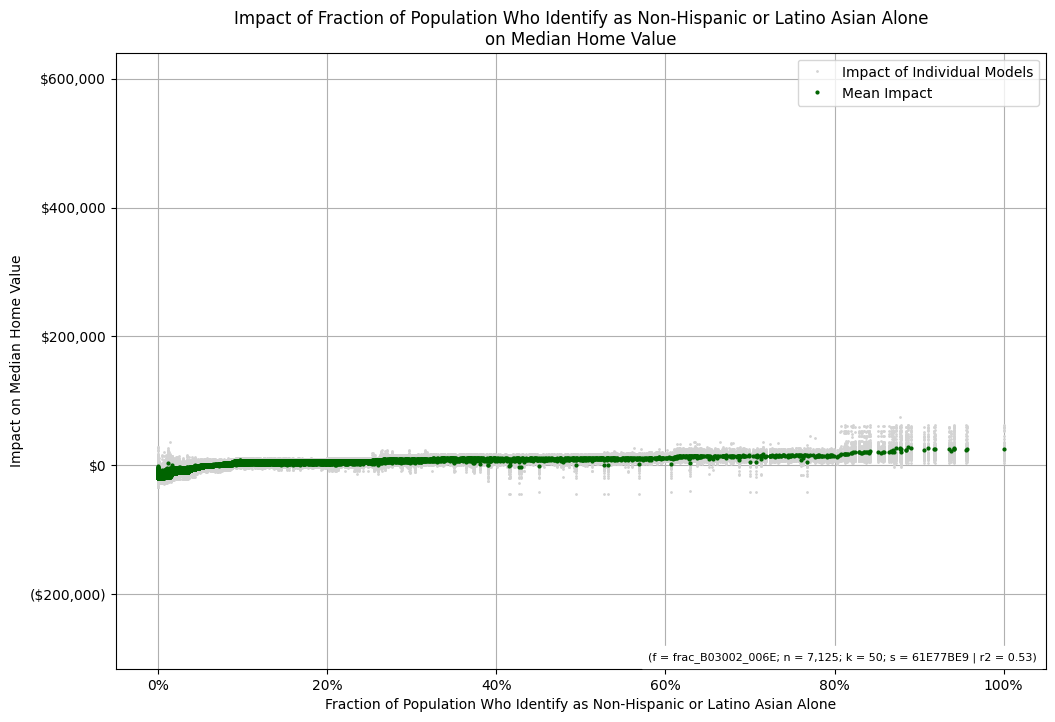

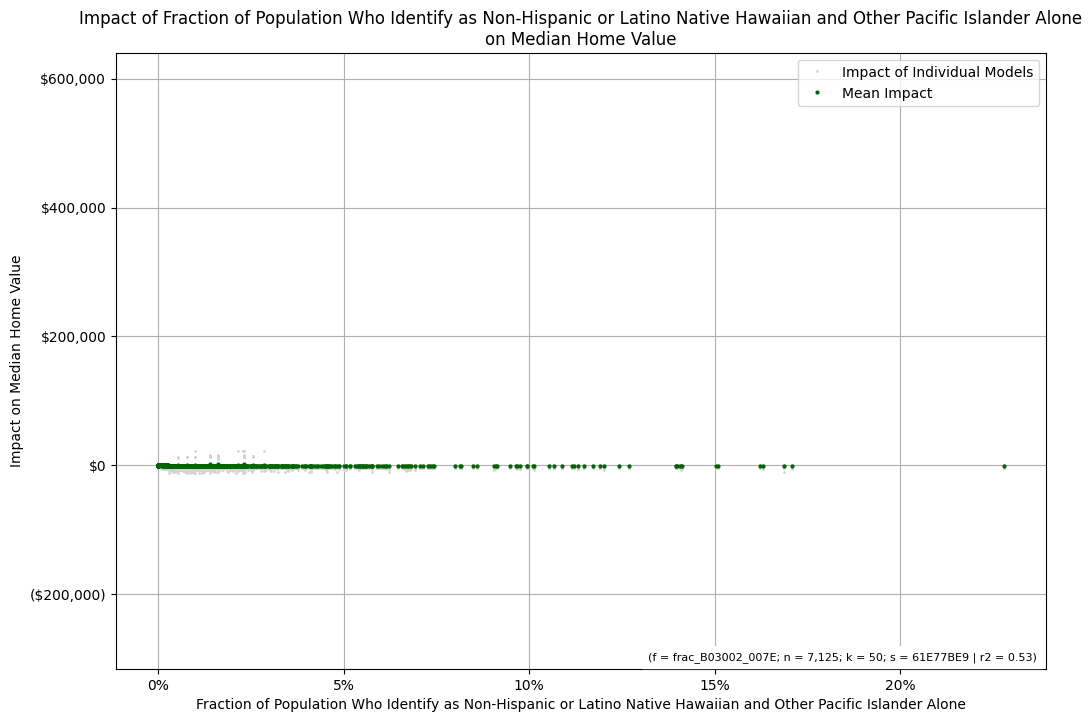

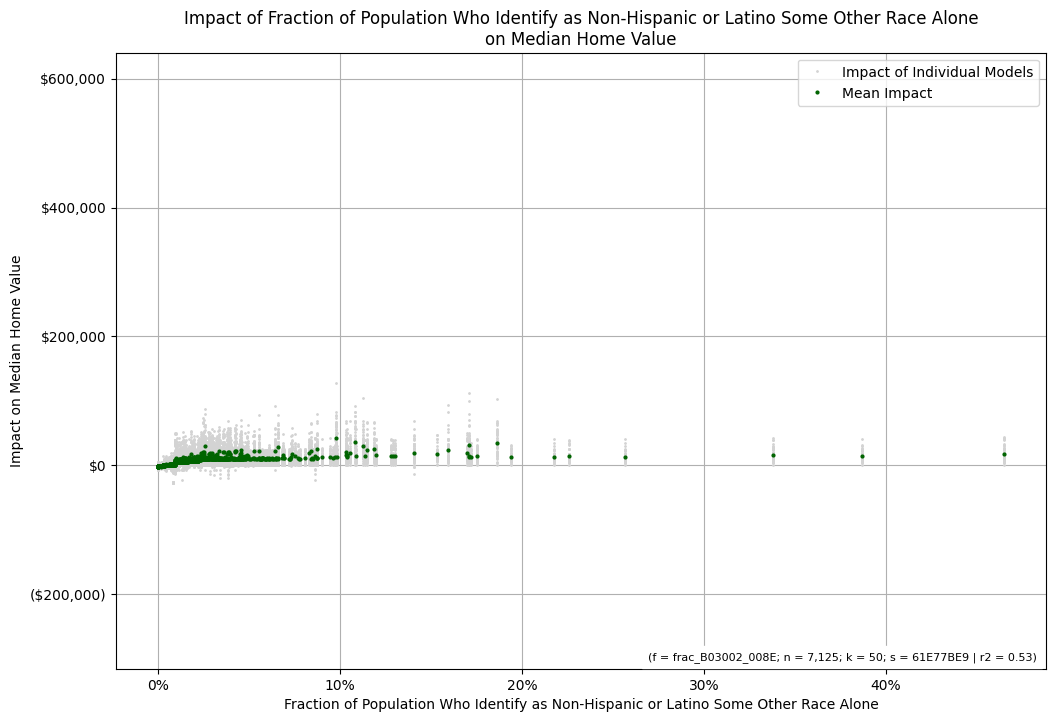

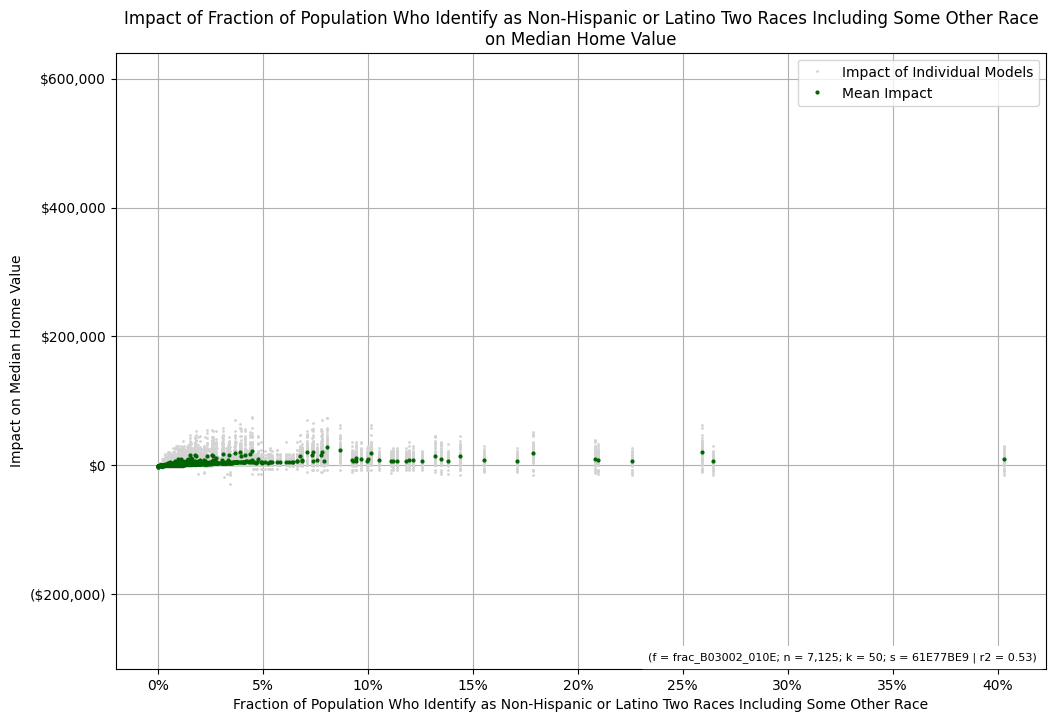

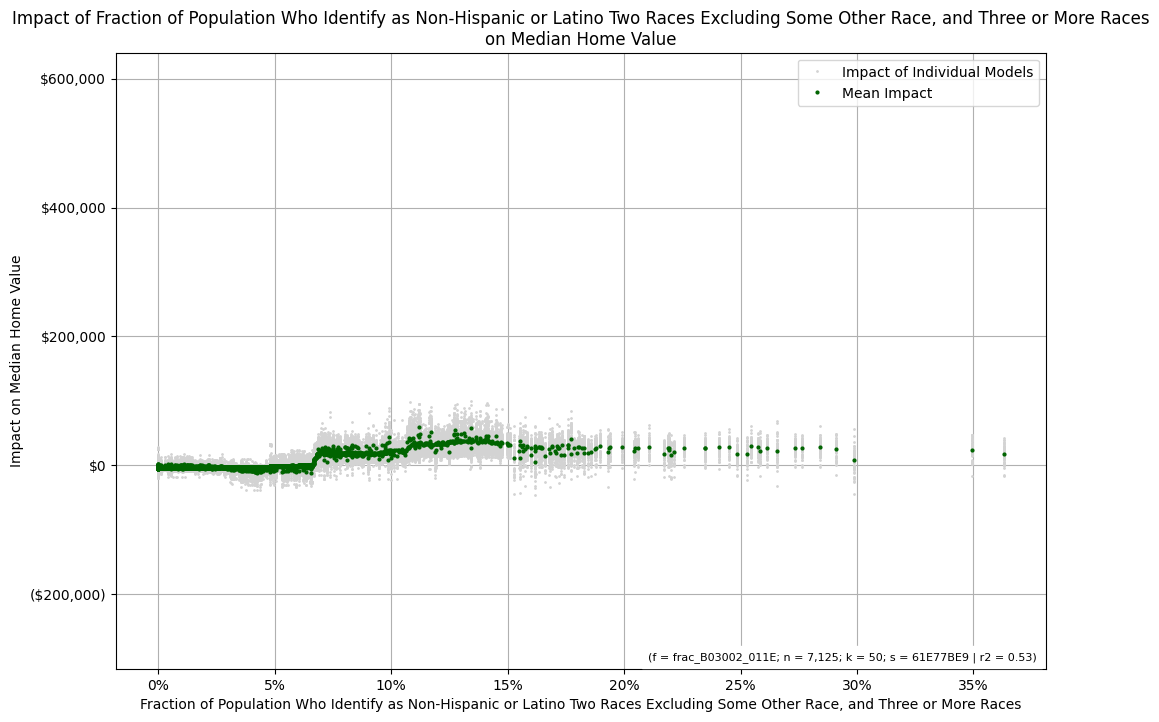

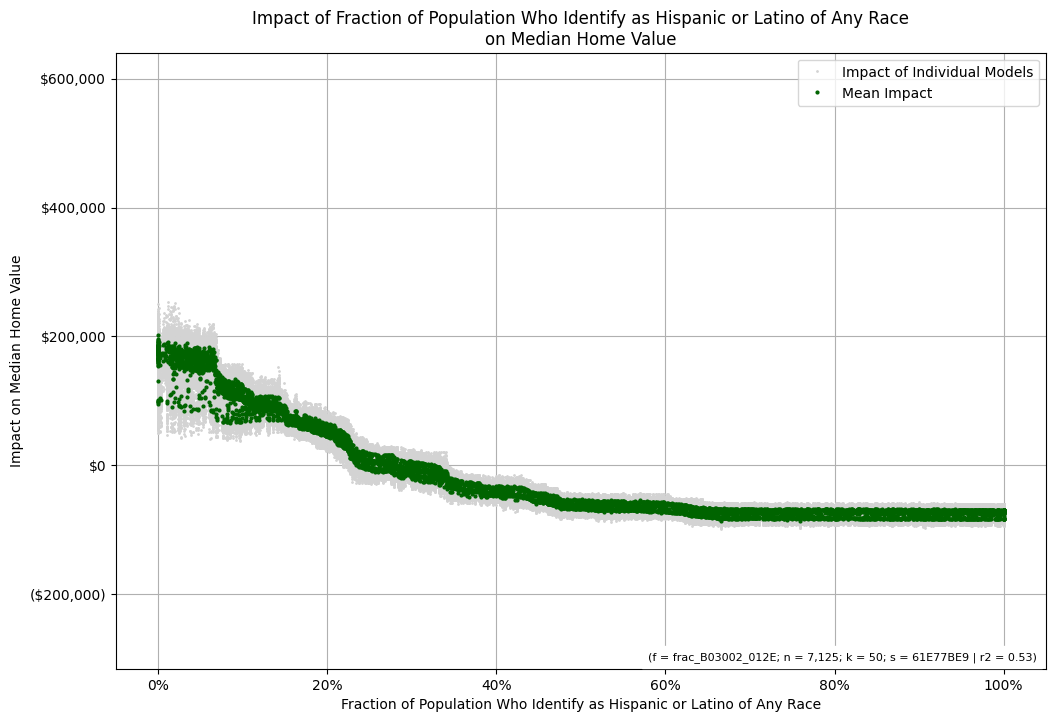

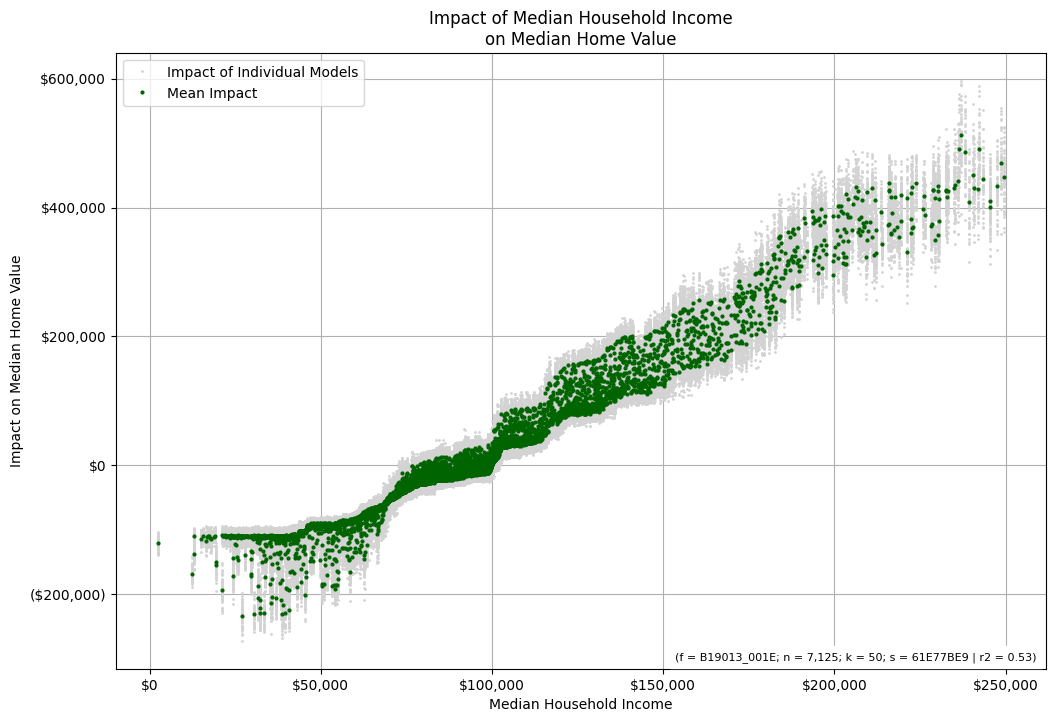

In [8]:
%%time

# This is where the heavy lifting of generating the impact charts happens:

impact_charts = impact_model.impact_charts(
    X,
    X.columns,
    subplots_kwargs=dict(
        figsize=(12, 8),
    ),
    feature_names=feature_names,
    y_name=target_name,
)

# This is just some post-processing to format the axes nicely on a per-feature basis.
# The y axis is always dollars. The x axis is a percentage for demographic features
# and dollars for the median household income feature.

for fig, ax in impact_charts.values():
    ax.yaxis.set_major_formatter(dollar_formatter)

for feature, (fig, ax) in impact_charts.items():
    if feature == dataset.FEATURE_MEDIAN_HOUSEHOLD_INCOME:
        ax.xaxis.set_major_formatter(dollar_formatter)
    else:
        ax.xaxis.set_major_formatter(percent_formatter)